In [3]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('Tensorflow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

Tensorflow version: 2.0.0
Is using GPU? False


## Preprocess Data

The original dataset has 10 classes and 60,000 examples in the training set and 10,000 examples in the test set<br>
In order to speed up the model training process we will take a subset of this dataset, thus we will use only 3 classes instead of 10 and 15,000 training examples instead of 60,000<br>


In [4]:
def get_three_classes(x,y):
    # We are using the first 3 classes
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)
    
    # We are concatenating the three classes
    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0) 
    
    # We are selecting only those examples and labels that correspond to these indices
    x = x[indices]
    y = y[indices]
    
    # count is the number of examples we have selected after the concatenation
    count = x.shape[0]
    # By using the np.random.choice function, we shuffle these indices 
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    # We are now converting the labels to one hot encoded values
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 16s 0us/step


In [6]:
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


## Visualize Examples

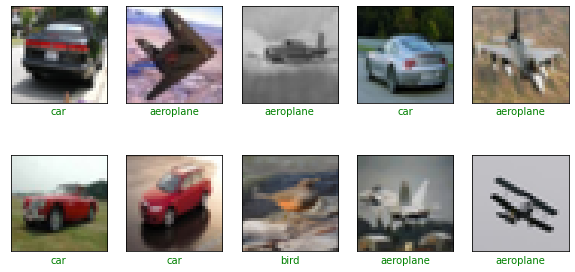

In [10]:
class_names = ['aeroplane','car','bird']
   
def show_random_examples(x,y,p):
    # the first argument gives the number of examples that exist in the set, the second argument gives the number of examples we are using and replace = False tells that all the examples will be unique
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x=x[indices]
    y=y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    
    plt.show()
    
show_random_examples(x_train, y_train, y_train) # Since we do no have any predictions now, we use the ground truth again which is the third argument here

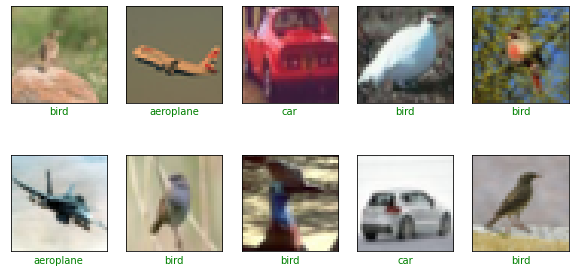

In [11]:
show_random_examples(x_test, y_test, y_test)

## Create Model

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [20]:
def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding = 'same'))
        model.add(BatchNormalization()) #This will have a regularization affect as well and its primarily used to ensure normalization of the previous layer at each batch.
        model.add(Conv2D(num_filters, 3, activation = 'relu')) # padding is left to default(valid)
        model.add(MaxPooling2D(pool_size=2))#This will reduce the rows and columns to half of the original value
        model.add(Dropout(0.5))
        return model
    
    # We will instantiate a keras sequential model and then add an input layer
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    #Now we will add 3 convolution blocks
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    #Output of the final convulation blocked will be flattened using the flatten layer
    model.add(Flatten())
    #Then we add a dense layer with 3 nodes and activation function set to softmax
    model.add(Dense(3, activation='softmax'))
    
    #Ultimately, we need the probability distribution across the 3 classes that we have
    model.compile(
        loss='categorical_crossentropy',
        optimizer = 'adam', metrics=['accuracy']
    )
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

## Train the model

In [22]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_(val_accuracy: .3f).h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
     ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 103s 7ms/sample - loss: 0.8963 - accuracy: 0.6791 - val_loss: 2.6423 - val_accuracy: 0.3333
Epoch 2/10
15000/15000 [==============================] - 86s 6ms/sample - loss: 0.5556 - accuracy: 0.7745 - val_loss: 2.3700 - val_accuracy: 0.3333
Epoch 3/10
15000/15000 [==============================] - 85s 6ms/sample - loss: 0.4850 - accuracy: 0.8065 - val_loss: 2.0286 - val_accuracy: 0.4540
Epoch 4/10
15000/15000 [==============================] - 85s 6ms/sample - loss: 0.4509 - accuracy: 0.8236 - val_loss: 0.9514 - val_accuracy: 0.6310
Epoch 5/10
15000/15000 [==============================] - 87s 6ms/sample - loss: 0.4223 - accuracy: 0.8304 - val_loss: 0.3798 - val_accuracy: 0.8490
Epoch 6/10
15000/15000 [==============================] - 86s 6ms/sample - loss: 0.3838 - accuracy: 0.8496 - val_loss: 0.3180 - val_accuracy: 0.8770
Epoch 7/10
15000/15000 [==============================] 

## Final Predictions

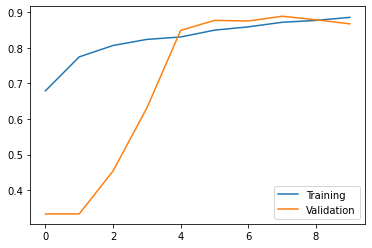

In [23]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [26]:
preds = model.predict(x_test/255.)

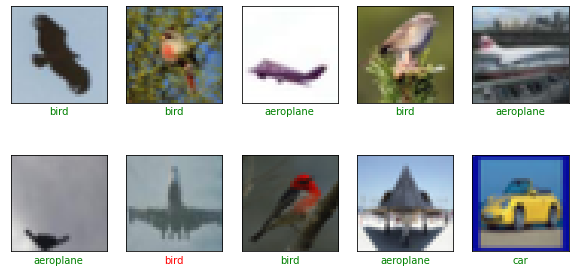

In [28]:
show_random_examples(x_test, y_test, preds)